# Bayesian Optimization
Idea: Use bayesian optimization for (wrapper) feature selection.

In [1]:
from sklearn import datasets
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from bayes_opt import BayesianOptimization
from itertools import chain, combinations
from itertools import compress
from skopt import gp_minimize
from skopt.space import Integer
import matplotlib.pyplot as plt
import numpy as np

## 0. Hyperparameters

## 1. Choose dataset

In [2]:
# regression dataset
dataset = datasets.load_boston()

In [3]:
# classification dataset
dataset = datasets.load_wine()

In [4]:
# classification dataset
dataset = datasets.load_breast_cancer()

## 2. Import dataset

In [5]:
# define which dataset should be used
data = dataset.data
data_target = dataset.target
feature_names = dataset.feature_names

data_frame = pd.DataFrame(data, columns = feature_names)
data_frame['Target'] = data_target
X = data_frame.drop("Target", 1)       # feature matrix
y = data_frame['Target'] 
data_frame.head()

#print(data)
#print(target_matrix)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 4. Bayesian Optimization Algorithm

### 4.1 Create feature-subsets (wrapper)

In [6]:
#s = feature_names 
#wrapper = list(combinations(s, k_features))

### 4.2  fmfn / BayesianOptimization Package 
- https://github.com/fmfn/BayesianOptimization

In [7]:
#pbounds_old = {'x': (0, len(wrapper)-1)}
#def black_box_function_bay_opt_old(x):
#    x = round(x)
#    filteredX = X[X.columns[X.columns.isin(wrapper[x])]] # use only selected features
#    model = LinearRegression().fit(filteredX, y)
#    return model.score(filteredX, y) # coefficient of determination


In [8]:
def black_box_function_bay_opt(**kwargs):
    current_features = []
    for k, v in kwargs.items():
        if bool(round(v)):
            current_features.append(k)
    filtered_X = X[X.columns[X.columns.isin(current_features)]]
    model = LinearRegression().fit(filtered_X, y)
    return model.score(filtered_X, y) # coefficient of determination

In [9]:
pbounds = {}
for feature_name in feature_names:
    pbounds[feature_name] = (0,1)

In [13]:
optimizer_fmfn = BayesianOptimization(
    f=black_box_function_bay_opt,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=123,
)

In [21]:
optimizer_fmfn.maximize(
    init_points=5,
    n_iter=10,
    acq = 'poi',
)

score_fmfn = optimizer_fmfn.max["target"]
res_fmfn_list = []
for k, v in optimizer_fmfn.max["params"].items():
    if bool(round(v)):
        res_fmfn_list.append(k)

res_fmfn = tuple(sorted(res_fmfn_list))
k_fmfn = len(res_fmfn)
#print(optimizer_fmfn.max["target"])
#print(round(optimizer_fmfn.max["params"]["x"]))

#res_fmfn = tuple(sorted(wrapper[round(optimizer_fmfn.max["params"]["x"])]))
print(score_fmfn)
res_fmfn

|   iter    |  target   | area e... | compac... | concav... | concav... | fracta... | mean area | mean c... | mean c... | mean c... | mean f... | mean p... | mean r... | mean s... | mean s... | mean t... | perime... | radius... | smooth... | symmet... | textur... | worst ... | worst ... | worst ... | worst ... | worst ... | worst ... | worst ... | worst ... | worst ... | worst ... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0.7577776401159324


('area error',
 'concave points error',
 'concavity error',
 'mean concavity',
 'mean perimeter',
 'mean radius',
 'perimeter error',
 'texture error',
 'worst area',
 'worst compactness',
 'worst concavity',
 'worst radius',
 'worst smoothness',
 'worst symmetry',
 'worst texture')

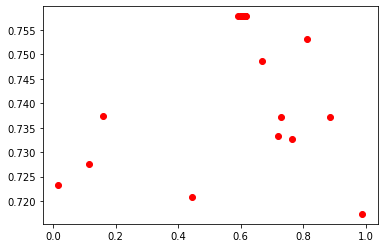

In [22]:
plot_x = []
plot_y = []
for element in optimizer_fmfn.res:
    plot_y.append(element['target'])
    plot_x.append(element['params']['mean radius'])

plt.plot(plot_x, plot_y, 'ro')
plt.show()

### 4.3 scikit-optimize (skopt)
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

In [16]:
#def black_box_function_scikit_optimize_old(x):
#    x = x[0]
#    
#    filteredX = X[X.columns[X.columns.isin(wrapper[x])]] # use only selected features
#    model = LinearRegression().fit(filteredX, y)
#    return 1-model.score(filteredX, y) # coefficient of determination


In [17]:
space  = []
for feature_name in feature_names:
    space.append(Integer(0, 1, name=feature_name))

In [18]:
def black_box_function_scikit_optimize(*args):
    current_features = list(compress(feature_names, args[0]))
    #print(current_features)
    filtered_X = X[X.columns[X.columns.isin(current_features)]]
    model = LinearRegression().fit(filtered_X, y)
    score = 1-model.score(filtered_X, y) # coefficient of determination
    #print(score)
    return score

In [24]:
optimizer_skopt = gp_minimize(black_box_function_scikit_optimize, # the function to minimize
                  space,      # the bounds on each dimension of x
                  acq_func="PI",      # the acquisition function
                  n_calls=20,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  #noise=0.1**2,       # the noise level (optional)
                  random_state=123,  # the random seed
                  verbose=False)  

score_skopt = 1-optimizer_skopt.fun
res_skopt = tuple(sorted(compress(feature_names, optimizer_skopt.x)))
k_skopt = len(res_skopt)
print(score_skopt)
print(res_skopt)

0.7668595623047086
('area error', 'concavity error', 'mean area', 'mean compactness', 'mean concave points', 'mean concavity', 'mean radius', 'mean texture', 'perimeter error', 'radius error', 'smoothness error', 'worst compactness', 'worst concave points', 'worst concavity', 'worst fractal dimension', 'worst perimeter', 'worst smoothness', 'worst symmetry')


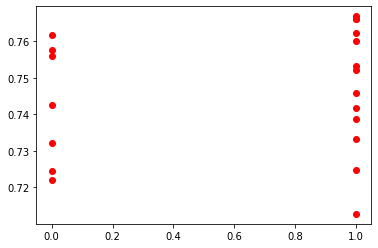

In [20]:
# Distribution of one specific feature
variable_index = 0
plot_x = [item[variable_index] for item in optimizer_skopt.x_iters]
plot_y = [1-i for i in optimizer_skopt.func_vals]
plt.plot(plot_x , plot_y, 'ro')
plt.show()

### 4.4 Bayesian Optimize k_feature


In [23]:
k_fmfn

15

In [25]:
k_skopt

18

In [26]:
k_features = k_skopt

## 3. Classical Feature Selection Algorithms

### 3.1 Sequential Forward Selection (mlxtend SFS)
- https://github.com/rasbt/mlxtend

In [27]:
forward_selection = SFS(LinearRegression(),
          k_features=k_features,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)

In [28]:
forward_selection.fit(X, y)
res_sfs = tuple(sorted(forward_selection.k_feature_names_))
res_sfs

('area error',
 'compactness error',
 'concave points error',
 'concavity error',
 'mean compactness',
 'mean concave points',
 'mean concavity',
 'mean radius',
 'mean texture',
 'radius error',
 'smoothness error',
 'worst area',
 'worst concave points',
 'worst concavity',
 'worst fractal dimension',
 'worst radius',
 'worst symmetry',
 'worst texture')

In [43]:
filtered_X = X[X.columns[X.columns.isin(res_sfs)]]
model = LinearRegression().fit(filtered_X, y)
score_sfs = model.score(filtered_X, y) # coefficient of determination

score_sfs

0.773123403101917

### 3.2 Recursive Feature Elimination (sklearn RFE)
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [29]:
rfe_selection = RFE(LinearRegression(),
               n_features_to_select=k_features,
               step=1)

In [30]:
rfe_selection.fit(X, y)
rfe_support = rfe_selection.support_

# convert to k-feature-names tuple
res_rfe_temp = []
for i in range(0,len(feature_names)):
    if rfe_support[i]:
        res_rfe_temp.append(feature_names[i])
res_rfe = tuple(sorted(res_rfe_temp)) # convert to tuple
res_rfe

('compactness error',
 'concave points error',
 'concavity error',
 'mean compactness',
 'mean concave points',
 'mean concavity',
 'mean fractal dimension',
 'mean smoothness',
 'mean symmetry',
 'perimeter error',
 'radius error',
 'smoothness error',
 'symmetry error',
 'worst concave points',
 'worst concavity',
 'worst fractal dimension',
 'worst smoothness',
 'worst symmetry')

In [44]:
filtered_X = X[X.columns[X.columns.isin(res_rfe)]]
model = LinearRegression().fit(filtered_X, y)
score_rfe = model.score(filtered_X, y) # coefficient of determination

score_rfe

0.7284294662027131

## 5. Results

In [31]:
# forward selection algorithm
res_sfs

('area error',
 'compactness error',
 'concave points error',
 'concavity error',
 'mean compactness',
 'mean concave points',
 'mean concavity',
 'mean radius',
 'mean texture',
 'radius error',
 'smoothness error',
 'worst area',
 'worst concave points',
 'worst concavity',
 'worst fractal dimension',
 'worst radius',
 'worst symmetry',
 'worst texture')

In [32]:
# recursive feature elimination
res_rfe

('compactness error',
 'concave points error',
 'concavity error',
 'mean compactness',
 'mean concave points',
 'mean concavity',
 'mean fractal dimension',
 'mean smoothness',
 'mean symmetry',
 'perimeter error',
 'radius error',
 'smoothness error',
 'symmetry error',
 'worst concave points',
 'worst concavity',
 'worst fractal dimension',
 'worst smoothness',
 'worst symmetry')

In [33]:
# fmfn bayesian optimization
res_fmfn

('area error',
 'concave points error',
 'concavity error',
 'mean concavity',
 'mean perimeter',
 'mean radius',
 'perimeter error',
 'texture error',
 'worst area',
 'worst compactness',
 'worst concavity',
 'worst radius',
 'worst smoothness',
 'worst symmetry',
 'worst texture')

In [34]:
# skopt bayesian optimization
res_skopt

('area error',
 'concavity error',
 'mean area',
 'mean compactness',
 'mean concave points',
 'mean concavity',
 'mean radius',
 'mean texture',
 'perimeter error',
 'radius error',
 'smoothness error',
 'worst compactness',
 'worst concave points',
 'worst concavity',
 'worst fractal dimension',
 'worst perimeter',
 'worst smoothness',
 'worst symmetry')

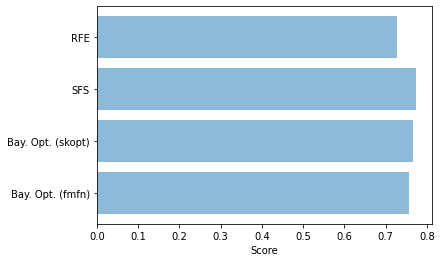

In [58]:
# bar chart of accuracy

objects = ('Bay. Opt. (fmfn)', 'Bay. Opt. (skopt)', 'SFS', 'RFE')
y_pos = np.arange(len(objects))
performance = [score_fmfn, score_skopt, score_sfs, score_rfe]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Score')

plt.savefig('score_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



In [66]:
len(set(res_sfs).intersection(set(res_skopt))) / len(set(res_sfs).union(set(res_skopt)))

0.5652173913043478